In [15]:
# 필요한 라이브러리 임포트
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import torchvision.models as models
import torchvision
from PIL import Image

In [16]:
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.pytorch import ToTensorV2
from augraphy import *
from augraphy.base.augmentationsequence import AugmentationSequence
from augraphy.augmentations import *

In [17]:
# # 데이터셋 클래스를 정의합니다.
# class ImageDataset(Dataset):
#     def __init__(self, csv, path, transform=None):
#         self.df = pd.read_csv(csv).values
#         self.path = path
#         self.transform = transform

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         name, target = self.df[idx, 0]
#         img = np.array(Image.open(os.path.join(self.path, name)))
#         if self.transform:
#             img = self.transform(img)
#         return img, target

class ImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file).values
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]  # 수정된 부분
        img_path = os.path.join(self.img_dir, name)
        img = np.array(Image.open(img_path))        
        
        if self.transform:
            augmented = self.transform(image=img)
            img = augmented['image']
        
        return img, int(target)

In [18]:
from augraphy import AugmentationSequence, InkBleed, ColorPaper, Markup, Scribbles, BleedThrough

In [19]:
# Define AugraphyTransform as before
class AugraphyTransform(ImageOnlyTransform):
    def __init__(self, p=0.7, always_apply=False):
        super(AugraphyTransform, self).__init__(p=p, always_apply=always_apply)
        # Define the Augraphy pipeline with desired augmentations
        self.pipeline = AugmentationSequence([
            # Ink bleed effect
            InkBleed(intensity_range=(0.1, 0.2), kernel_size=(3, 5), severity=(0.4, 0.6), p=0.5),
            # Paper color changes
            ColorPaper(hue_range=(-10, 10), saturation_range=(-30, 30), p=0.5),
            # Markup
            Markup(num_lines_range=(2, 5), p=0.5),
            # Scribbles
            Scribbles(scribbles_type="random", scribbles_ink="random", scribbles_location="random",
                      scribbles_size_range=(250, 600), scribbles_count_range=(1, 6), p=0.5),
            # BleedThrough effect
            BleedThrough(intensity_range=(0.1, 0.2), offsets=(10, 20), p=0.5),
        ])

    def apply(self, img, **params):
        if not isinstance(img, np.ndarray):
            img = np.array(img)
        augmented_image = self.pipeline(img)[0]
        return augmented_image

In [20]:
# Define transformations with and without AugraphyTransform
def get_transform(with_augraphy=True):
    transform = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(),
    ToTensorV2(),
])
    if with_augraphy:
        transforms.insert(4, AugraphyTransform(p=0.7))  # Insert AugraphyTransform before normalization
    return A.Compose(transforms)

In [21]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, random_split

def get_transform(config, is_train=True):
    transforms = [
        A.Resize(height=config.image_size, width=config.image_size),
        A.Normalize(),
    ]
    if is_train:
        transforms.insert(1, A.HorizontalFlip(p=0.5))
        if config.use_augraphy:
            transforms.insert(1, AugraphyTransform(p=0.7))  # AugraphyTransform 정의 필요
    transforms.append(ToTensorV2())
    return A.Compose(transforms)

def get_dataloaders(config, split=None):
    full_dataset = ImageDataset(
        os.path.join(config.base_dir, "code", "trin4.csv"),
        config.train_data_dir,
        transform=get_transform(config, is_train=True)
    )
    
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    
    test_dataset = ImageDataset(
        os.path.join(config.base_dir, "data", "data", "sample_submission.csv"),
        config.val_data_dir,
        transform=get_transform(config, is_train=False)
    )
    
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers, pin_memory=True)
    
    if split == 'train':
        return train_dataset, train_loader
    elif split == 'val':
        return val_dataset, val_loader
    elif split == 'test':
        return test_dataset, test_loader
    else:
        return train_loader, val_loader, test_loader, test_dataset

In [22]:
import os
import torch
from typing import List, Tuple

class Config:
    def __init__(self):
        self.base_dir: str = '/root/CV_PJT/CV_PJT'
        self.train_data_dir: str = os.path.join(self.base_dir, 'data', 'data', 'train')
        self.val_data_dir: str = os.path.join(self.base_dir, 'data', 'data', 'test') 
        self.batch_size: int = 32 
        self.num_workers: int = 4
        self.image_size: int = 260  # Example size for ResNet or EfficientNet
        self.use_augraphy: bool = False  # Set this according to your needs
        self.device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.output_dir: str = os.path.join(self.base_dir, 'code', 'ensemble', 'em_output')
        
        # Model weight path settings
        self.models_info: List[Tuple[str, str]] = [
            ("efficientnet_b4", "/root/CV_PJT/CV_PJT/model/entire_model_effib4_all_epo7.pth"),
            ("efficientnet_b0", "/root/CV_PJT/CV_PJT/model/entire_model_effib0_epo14.pth"),
            ("resnet50", "/root/CV_PJT/CV_PJT/model/model_resnet50_best.pt"),
            ("resnext50_32x4d", "/root/CV_PJT/CV_PJT/model/entire_model_resnext_(3).pth"),            
            ("densenet121", "/root/CV_PJT/CV_PJT/model/model_densenet121_224_best.pt"),
            ("efficientnet_b3", "/root/CV_PJT/CV_PJT/model/model_baseline_last_3,7.pt"),
            ("efficientnet_b3", "/root/CV_PJT/CV_PJT/model/model_baseline_last_4,14.pt"),
            ("efficientnet_b3", "/root/CV_PJT/CV_PJT/model/model_baseline_last_3,4,7,14.pt")            
        ]
        self.num_classes: int = 17  # Adjust based on your classification task

    def __str__(self) -> str:
        return f"Config(train_data_dir={self.train_data_dir}, val_data_dir={self.val_data_dir}, " \
               f"batch_size={self.batch_size}, num_workers={self.num_workers}, " \
               f"image_size={self.image_size}, use_augraphy={self.use_augraphy}, " \
               f"device={self.device}, output_dir={self.output_dir}, " \
               f"num_classes={self.num_classes})"

    def __repr__(self) -> str:
        return self.__str__()

In [207]:
# pip install --upgrade timm

In [29]:
import timm

In [27]:
import torchvision.models as models
import torch.nn as nn
import torch

def get_model(model_name, config, device):
    model = timm.create_model(model_name, pretrained=True, num_classes=config.num_classes)
    return model

In [210]:
# print(type(models))
# print(dir(models))

In [24]:
import torch
import torchvision.models as models  # Make sure to import the models module

In [212]:
# models.

In [30]:
from torchvision.models import swin_b, resnext50_32x4d, efficientnet_b0, efficientnet_b3, efficientnet_b4, resnet152, densenet121, resnet101, resnet50
from torchvision.models import Swin_B_Weights, ResNeXt50_32X4D_Weights, EfficientNet_B0_Weights, EfficientNet_B3_Weights, EfficientNet_B4_Weights, ResNet152_Weights, DenseNet121_Weights, ResNet101_Weights, ResNet50_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

WeightsEnum.get_state_dict = get_state_dict

# 모델 초기화
model1 = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model2 = resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)
model3 = efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)
model4 = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
model5 = resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)
model6 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model7 = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
model8 = resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1)
model9 = swin_b(weights=Swin_B_Weights.IMAGENET1K_V1)

# 모델 리스트
models = [model1, model2, model3, model4, model5, model6, model7, model8, model9]

In [31]:
# 설정
config = Config()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 모델 가중치 경로 설정
models_info = [
    ("efficientnet_b4", "/root/CV_PJT/CV_PJT/model/entire_model_effib4_all_epo7.pth"),
    ("efficientnet_b0", "/root/CV_PJT/CV_PJT/model/entire_model_effib0_epo14.pth"),
    ("resnet50", "/root/CV_PJT/CV_PJT/model/model_resnet50_best.pt"),
    ("resnext50_32x4d", "/root/CV_PJT/CV_PJT/model/entire_model_resnext_(3).pth"),            
    ("densenet121", "/root/CV_PJT/CV_PJT/model/model_densenet121_224_best.pt"),
    ("efficientnet_b3", "/root/CV_PJT/CV_PJT/model/model_baseline_last_3,7.pt"),
    ("efficientnet_b3", "/root/CV_PJT/CV_PJT/model/model_baseline_last_4,14.pt"),
    ("efficientnet_b3", "/root/CV_PJT/CV_PJT/model/model_baseline_last_3,4,7,14.pt")
    # 추가 모델들...
]

# 데이터 로더 생성
train_loader, val_loader, test_loader, test_dataset = get_dataloaders(config)

class EnsembleModel:
    def __init__(self, models, device):
        self.models = models
        self.device = device
        
    def predict_proba(self, dataloader):
        all_predictions = []
        
        for model in self.models:
            model.eval()
            model_predictions = []
            
            with torch.no_grad():
                for inputs, _ in tqdm(dataloader, desc=f"Model predictions"):
                    inputs = inputs.to(self.device)
                    outputs = model(inputs)
                    probas = torch.softmax(outputs, dim=1)
                    model_predictions.append(probas.cpu().numpy())
            
            all_predictions.append(np.concatenate(model_predictions))
        
        return np.mean(all_predictions, axis=0)

    def predict(self, dataloader):
        probas = self.predict_proba(dataloader)
        return np.argmax(probas, axis=1)

class StackingEnsemble:
    def __init__(self, base_models, meta_model, device):
        self.base_models = base_models
        self.meta_model = meta_model
        self.device = device
        
    def create_meta_features(self, dataloader):
        all_predictions = []
        
        for model in self.base_models:
            model.eval()
            model_predictions = []
            
            with torch.no_grad():
                for inputs, _ in tqdm(dataloader, desc=f"Creating meta-features"):
                    inputs = inputs.to(self.device)
                    outputs = model(inputs)
                    probas = torch.softmax(outputs, dim=1)
                    model_predictions.append(probas.cpu().numpy())
            
            all_predictions.append(np.concatenate(model_predictions))
        
        return np.column_stack(all_predictions)
        
    def fit(self, train_loader):
        print("Creating meta-features for training...")
        meta_features = self.create_meta_features(train_loader)
        
        true_labels = []
        for _, labels in train_loader:
            true_labels.extend(labels.numpy())
        
        print("Training meta model...")
        self.meta_model.fit(meta_features, np.array(true_labels))
        
    def predict(self, test_loader):
        meta_features = self.create_meta_features(test_loader)
        return self.meta_model.predict(meta_features)


# 모델 로드
models = []
for model_name, weight_path in models_info:
    print(f"Loading {model_name}...")
    model = get_model(model_name, config, device)
    
    # 가중치 로드
    state_dict = torch.load(weight_path, map_location=device)
    
    # 로드된 객체가 state_dict인지 확인
    if isinstance(state_dict, dict) and "state_dict" in state_dict:
        # 전체 체크포인트가 저장된 경우
        model.load_state_dict(state_dict["state_dict"], strict=False)
    elif isinstance(state_dict, dict):
        # state_dict만 저장된 경우
        model.load_state_dict(state_dict, strict=False)
    else:
        # 전체 모델이 저장된 경우
        model = state_dict
    
    model.to(device)
    model.eval()  # 평가 모드로 설정
    models.append(model)

print("\nAll models loaded successfully!")

Using device: cuda
Loading efficientnet_b4...
Loading efficientnet_b0...
Loading resnet50...
Loading resnext50_32x4d...
Loading densenet121...
Loading efficientnet_b3...
Loading efficientnet_b3...
Loading efficientnet_b3...

All models loaded successfully!


In [215]:
# Soft Voting 앙상블
print("Performing Soft Voting ensemble...")
soft_voting = EnsembleModel(models, device)
soft_voting_preds = soft_voting.predict(test_loader)

# Define the output directory
output_dir = '/root/CV_PJT/CV_PJT/code/ensemble/em_output'

# 결과 저장
timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")

# Soft Voting 결과 저장
soft_voting_df = pd.DataFrame({
    'ID': test_dataset.df[:, 0],
    'target': soft_voting_preds
})

soft_voting_filename = os.path.join(output_dir, f"predictions_soft_voting_{timestamp}.csv")
soft_voting_df.to_csv(soft_voting_filename, index=False)
print(f"Saved soft voting predictions to: {soft_voting_filename}")

Performing Soft Voting ensemble...


Model predictions:   0%|          | 0/99 [00:00<?, ?it/s]

Model predictions:   0%|          | 0/99 [00:00<?, ?it/s]

Model predictions:   0%|          | 0/99 [00:00<?, ?it/s]

Model predictions:   0%|          | 0/99 [00:00<?, ?it/s]

Model predictions:   0%|          | 0/99 [00:00<?, ?it/s]

Model predictions:   0%|          | 0/99 [00:00<?, ?it/s]

Model predictions:   0%|          | 0/99 [00:00<?, ?it/s]

Model predictions:   0%|          | 0/99 [00:00<?, ?it/s]

Saved soft voting predictions to: /root/CV_PJT/CV_PJT/code/ensemble/em_output/predictions_soft_voting_20241107_041139.csv


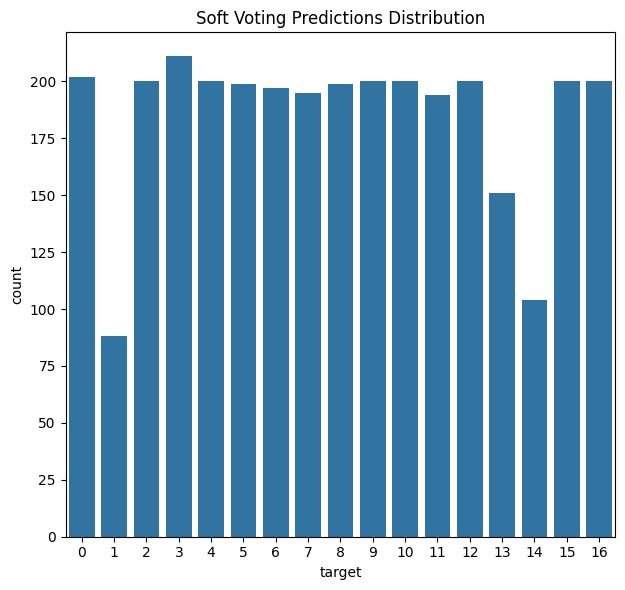

In [218]:
# 추가로 성능 시각화를 위한 코드
def plot_prediction_distribution():
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.countplot(data=soft_voting_df, x='target')
    plt.title('Soft Voting Predictions Distribution')
    
    
    plt.tight_layout()
    plt.show()

plot_prediction_distribution()